In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
import seaborn as sns
from scipy.stats import pearsonr
import optuna

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

c:\Users\lysov\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def gen_lagged_data(metadata, data, last_date, lag):
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [2]:
data = pd.read_excel("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/data_tf.xlsx", decimal = ',', parse_dates=["date"])
metadata = pd.read_csv("C:/Users/lysov/Desktop/4 курс/ВКР/New Data/meta_data.csv", delimiter = ";")
data_num = data.loc[:, data.columns != 'date']


target_variable = "gdp"

lags = list(range(-2, 3))

train_start_date = "2011-01-01"
train_end_date = "2018-12-01"
test_start_date = "2019-03-01"
test_end_date = "2023-09-01"

test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)


In [ ]:
# names = ['date', 'gdp',
#         #  # sectors
#         #  'agri', 'mining', 'manufacturing', 'egpiv', 'construction', 'trade', 'transport', 'finance', 'real_estate', 'others', 'taxes',
#         #  # PMI
#          'PMI_Mnf', 'PMI_Serv', 'PMI_Comp',
#          # IBC total
#          'IBC_total',  'IBC_total_fact', 'IBC_total_3m', 'IBC_total_output', 'IBC_total_output_3m', 'IBC_total_demand',
#          'IBC_total_demand_3m', 'IBC_total_price', 'IBC_total_price_3m','IBC_total_costs', 'IBC_total_credit',
#          # IBC ip
#          'IBC_ip', 'IBC_ip_fact', 'IBC_ip_3m', 'IBC_ip_output', 'IBC_ip_output_3m', 'IBC_ip_demand',
#          'IBC_ip_demand_3m', 'IBC_ip_price', 'IBC_ip_price_3m', 'IBC_ip_costs', 'IBC_ip_credit', 
#          # IBC mining
#          'IBC_mining', 'IBC_mining_fact', 'IBC_mining_3m', 'IBC_mining_output', 'IBC_mining_output_3m', 'IBC_mining_demand',
#          'IBC_mining_demand_3m', 'IBC_mining_price', 'IBC_mining_price_3m', 'IBC_mining_costs', 'IBC_mining_credit',
#          # IBC manufacturing
#          'IBC_mnf', 'IBC_mnf_fact', 'IBC_mnf_3m', 'IBC_mnf_output', 'IBC_mnf_output_3m', 'IBC_mnf_demand',
#          'IBC_mnf_demand_3m', 'IBC_mnf_price', 'IBC_mnf_price_3m', 'IBC_mnf_costs', 'IBC_mnf_credit',
#          # IBC constr
#          'IBC_constr', 'IBC_constr_fact', 'IBC_constr_3m', 'IBC_constr_output','IBC_constr_output_3m', 'IBC_constr_demand',
#          'IBC_constr_demand_3m', 'IBC_constr_price', 'IBC_constr_price_3m', 'IBC_constr_costs', 'IBC_constr_credit',
#          # IBC trade
#          'IBC_trade', 'IBC_trade_fact', 'IBC_trade_3m', 'IBC_trade_output', 'IBC_trade_output_3m', 'IBC_trade_demand',
#          'IBC_trade_demand_3m', 'IBC_trade_price', 'IBC_trade_price_3m', 'IBC_trade_costs', 'IBC_trade_credit',
#          # IBC transp
#          'IBC_transp', 'IBC_transp_fact', 'IBC_transp_3m', 'IBC_transp_output', 'IBC_transp_output_3m', 'IBC_transp_demand', 
#          'IBC_transp_demand_3m', 'IBC_transp_price', 'IBC_transp_price_3m', 'IBC_transp_costs', 'IBC_transp_credit',
#          # IBC serv
#          'IBC_serv', 'IBC_serv_fact', 'IBC_serv_3m', 'IBC_serv_output', 'IBC_serv_output_3m', 'IBC_serv_demand',
#          'IBC_serv_demand_3m', 'IBC_serv_price', 'IBC_serv_price_3m', 'IBC_serv_costs', 'IBC_serv_credit',
#          # hse + rspp
#         'hse', 'rspp1', 'rspp2', 'rspp3', 'rspp4', 'rspp5', 'rspp6', 'rspp7',
#          # ipu rosstat
#          'ipu_constr1', 'ipu_constr2', 'ipu_constr3',
#          # ip
#          'ip', 'ip_raw',  'ip_coal', 'ip_oil_products',
#          'ip_chemicals', 'ip_man', 'ip_metals', 'ip_food', 'ip_cars', 'ip_el',
#          # rail + cargo
#          'rail', 'cargo_rail', 'cargo_auto', 'cargo_sea', 'cargo_pipe',
#          # constr
#          'constr_vol', 'constr_prices',
#          # serv
#          'retail_prod', 'retail_neprod', 'pserv', 'obschepit',
#          # labor
#          'dispinc', 'eap', 'unemp', 'nwage',
#          # cars
#          'cars', 'trucks',
#          # financial
#          'miacr', 'rtc', 'moex', 'reer', 'rvi', 'm0', 'm2x', 'ofz1', 'ofz3', 'ofz5', 'ofz10',
#          # dep/cred rates 
#          'dep_hh_rate', 'dep_nfo_rate', 'cred_hh_rate', 'cred_nfo_rate',
#          # ust
#          't2', 't10',
#          # external conditions
#          'ism_man', 'ism_serv', 'us_cpi', 'eu_cpi', 'cpi', 'cpi_prod', 'cpi_neprod', 'cpi_serv', 'ppi',
#          'brent', 'urals', 'aluminium', 'gold', 'gas'
#          ]

# data = data.loc[:, names]
# # test dataset
# test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

<Axes: >

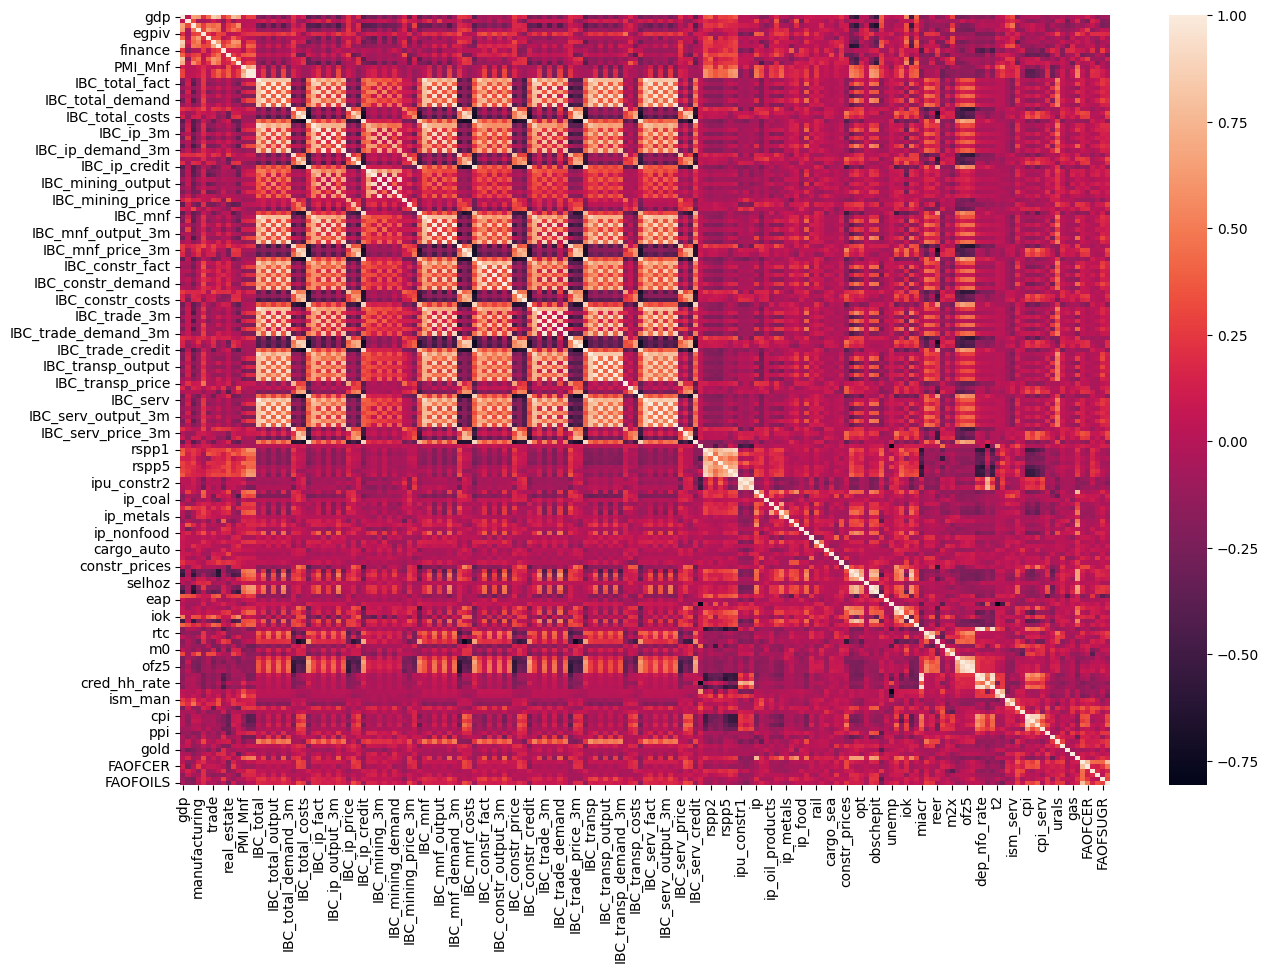

In [4]:
sns.heatmap(data_num.corr(method='pearson'))

In [4]:
corr = data_num.corr(method='pearson')

# remove highly correlated predictors
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data_num.columns[columns].insert(0, 'date')

data_selected = data.loc[:, selected_columns]
test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)

In [5]:
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return p

In [6]:
data_num = data.loc[:, data.columns != 'date']
pvals = r_pvalues(data_num)

In [7]:
pvals['gdp'].sort_values().head(20)

gdp                    0.0
retail_neprod          0.0
mining                 0.0
manufacturing          0.0
iok                    0.0
trade                  0.0
transport              0.0
taxes                  0.0
others                 0.0
obschepit           0.0001
cars                0.0002
retail_prod         0.0008
construction        0.0016
rspp2               0.0035
trucks              0.0036
dispinc             0.0042
IBC_ip_credit       0.0043
real_estate         0.0043
IBC_trade_credit    0.0048
IBC_total_credit    0.0056
Name: gdp, dtype: object

In [8]:
def nowcast_elastic(model_params, target_variable, dates, actuals):
    
    selected_columns = data_num.loc[:, pvals[target_variable] < model_params['pval']].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected

    pred_dict = {k: [] for k in lags}
    try:
        for date in dates:
            train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:] 
            transformed_train = mean_fill_dataset(train, train)
            transformed_train = flatten_data(transformed_train, target_variable, model_params['flat'])
            transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
            
            model = ElasticNet(alpha = model_params['alpha'], l1_ratio=model_params['l1'])
            x = transformed_train.drop(["date", target_variable], axis=1)
            y = transformed_train[target_variable]
            model.fit(x, y)
            
            for lag in lags:
                tmp_data = gen_lagged_data(metadata, test_t, date, lag)

                tmp_data = mean_fill_dataset(train, tmp_data)
                tmp_data = flatten_data(tmp_data, target_variable, model_params['flat'])
                x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
                
                pred = model.predict(x)[0]
                pred_dict[lag].append(pred)
                  
        curr_MAE = np.mean(np.abs((np.array(actuals) - np.array(pred_dict[2]))))
    except: curr_MAE = 1000

    return curr_MAE

In [9]:
def objective(trial):
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )
    
    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    pval = trial.suggest_loguniform('pval', 1e-5, 1)
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e5)
    l1 = trial.suggest_discrete_uniform('l1', 0, 1 , 0.1)
    flat = trial.suggest_int('flat', 2, 7, step=1)

    model_params = {'pval': pval, 'alpha': alpha, "l1": l1, "flat": flat}
    
    return nowcast_elastic(model_params, target_variable=target_variable, dates=dates, actuals=actuals)
    


In [ ]:
# def try_elastic(data, target_variable, alpha_min, alpha_max, num_alpha, num_l1, pval_list, flat_list):

#     dates = (
#         pd.date_range(test_start_date, test_end_date, freq="3MS")
#         .strftime("%Y-%m-%d")
#         .tolist()
#     )

#     # actual values
#     actuals = list(test.loc[test.date.isin(dates), target_variable].values)
#     count = 0
#     best_flat = 3
#     best_alpha = 0
#     best_l1 = 0.5
#     best_pval = 1
#     best_MAE = 2000

#     for pval in pval_list:
#         selected_columns = data_num.loc[:, pvals[target_variable] < pval].columns
#         selected_columns = selected_columns.insert(0, 'date')
#         data_selected = data.loc[:, selected_columns]
#         test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
#         test_t = test_selected
#         try:
#             for curr_alpha in np.linspace(start=alpha_min, stop=alpha_max, num=num_alpha):
#                 for curr_l1 in np.linspace(start=0, stop=1, num=num_l1):    
#                     curr_MAE = nowcast_elastic(test_t=test_t, target_variable=target_variable, alpha=curr_alpha, l1=curr_l1, flat=3, dates=dates, actuals=actuals)
#                     count += 1
#                     print(f'{count}/{num_alpha*len(pval_list)*num_l1}: {round(curr_MAE, 3)}')
#                     if curr_MAE <= best_MAE:
#                         best_MAE = curr_MAE
#                         best_alpha = curr_alpha
#                         best_l1 = curr_l1
#                         best_pval = pval
#                         print(f'Best MAE: {round(best_MAE, 5)} with alpha = {best_alpha}, l1 = {best_l1}, pval = {pval}')
#         except:
#             pass
    
#     selected_columns = data_num.loc[:, pvals[target_variable] < best_pval].columns
#     selected_columns = selected_columns.insert(0, 'date')
#     data_selected = data.loc[:, selected_columns]
#     test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
#     test_t = test_selected

#     for flat in flat_list:
#         curr_MAE = nowcast_elastic(test_t=test_t, target_variable=target_variable, alpha=curr_alpha, l1=curr_l1, flat=flat, dates=dates, actuals=actuals)
#         print(round(curr_MAE, 3))
#         if curr_MAE <= best_MAE:
#             best_MAE = curr_MAE
#             best_alpha = best_alpha
#             best_pval = best_pval
#             best_flat = flat
#             print(f'Best MAE: {round(best_MAE, 5)} with alpha = {best_alpha}, l1 = {best_l1}, pval = {pval}, flat = {best_flat}')
            
#         output = [target_variable, best_alpha, best_l1, best_pval, best_flat, best_MAE]
#     return output

In [10]:
def evaluate_elastic(data, model_params, target_variable, plot, save):
    target_variable = target_variable
    alpha = model_params['alpha']
    l1 = model_params['l1']
    pval = model_params['pval']
    flat = model_params['flat']
    
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    selected_columns = data_num.loc[:, pvals[target_variable] < pval].columns
    selected_columns = selected_columns.insert(0, 'date')
    data_selected = data.loc[:, selected_columns]
    test_selected = data_selected.loc[(data_selected.date >= train_start_date) & (data_selected.date <= test_end_date), :].reset_index(drop=True)
    test_t = test_selected
    
    pred_dict = {k: [] for k in lags}
    for date in dates:
        train = test_t.loc[test_t.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:] 
        transformed_train = mean_fill_dataset(train, train)
        transformed_train = flatten_data(transformed_train, target_variable, flat)
        transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
        
        model = ElasticNet(alpha = alpha, l1_ratio=l1)
        x = transformed_train.drop(["date", target_variable], axis=1)
        y = transformed_train[target_variable]
        model.fit(x, y)
        
        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test_t, date, lag)

            tmp_data = mean_fill_dataset(train, tmp_data)
            tmp_data = flatten_data(tmp_data, target_variable, flat)
            x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
            
            pred = model.predict(x)[0]
            pred_dict[lag].append(pred)
    
    performance = pd.DataFrame(columns=["Vintage", "RMSE", "MAE"])
    for lag in lags:
        tmp = pd.DataFrame({
            "Vintage":lag,
            "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2)),
            "MAE":np.mean(np.abs((np.array(actuals) - np.array(pred_dict[lag]))))
        }, index=[0])
        performance = pd.concat([performance, tmp]).reset_index(drop=True)
    
    print(performance.round(4))

    if plot == 1:
        predictions_elastic = pd.DataFrame({
            "actuals":actuals, 
            "two_back":pred_dict[-2], 
            "one_back":pred_dict[-1], 
            "zero_back":pred_dict[0],
            "one_ahead":pred_dict[1],
            "two_ahead":pred_dict[2]}
        )
        predictions_elastic.plot()

    if save == 1:
        predictions_elastic.to_excel(f"predictions_{target_variable}_elastic.xlsx")
        

In [40]:
target_variable = 'gdp'
study = optuna.create_study()
study.optimize(objective, n_trials = 200)
gdp_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-25 16:59:07,922] A new study created in memory with name: no-name-fe8f1bea-97b7-47bb-94c8-48d6ebed8ea6
[I 2024-04-25 16:59:10,991] Trial 0 finished with value: 1.732763106956593 and parameters: {'pval': 1.7290371915304857e-05, 'alpha': 1030.355710119436, 'l1': 0.7000000000000001, 'flat': 7}. Best is trial 0 with value: 1.732763106956593.
[I 2024-04-25 16:59:12,542] Trial 1 finished with value: 1.7201847402831858 and parameters: {'pval': 0.00035283902402332107, 'alpha': 649.6534208182366, 'l1': 0.6000000000000001, 'flat': 2}. Best is trial 1 with value: 1.7201847402831858.
[I 2024-04-25 16:59:16,841] Trial 2 finished with value: 1.3848791840627737 and parameters: {'pval': 0.06483917777965842, 'alpha': 3.508049358020254, 'l1': 0.9, 'flat': 5}. Best is trial 2 with value: 1.3848791840627737.
[I 2024-04-25 16:59:22,353] Trial 3 finished with value: 1.350542595069336 and parameters: {'pval': 0.14710360500380476, 'alpha': 0.5523539347877828, 'l1': 0.0, 'flat': 3}. Best is trial 3 

Best MAE=1.0114075412203047, best parameters:{'pval': 0.018345567633641487, 'alpha': 0.033845784402608416, 'l1': 0.0, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  2.8407  1.7067
1      -1  2.6368  1.5746
2       0  2.5756  1.5797
3       1  1.6447  1.1095
4       2  1.4928  1.0114


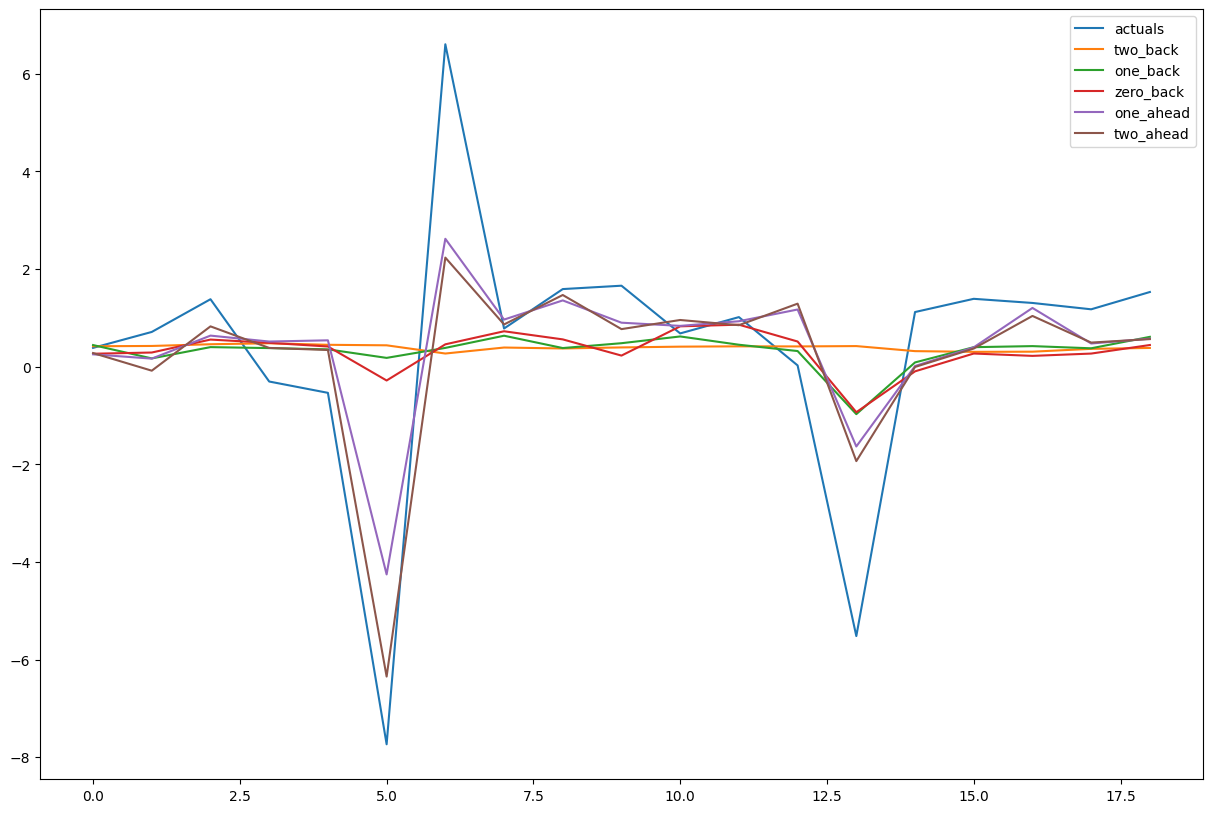

In [42]:
evaluate_elastic(data = data, target_variable='gdp', model_params=gdp_opt, plot=1, save=1)

In [65]:
target_variable = 'agri'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
agri_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-25 19:58:24,167] A new study created in memory with name: no-name-02d0bce4-ba97-4394-b9e8-e258b94459f2
[I 2024-04-25 19:58:24,242] Trial 0 finished with value: 1000.0 and parameters: {'pval': 0.0005828537149659538, 'alpha': 5.361768670900839, 'l1': 0.9, 'flat': 6}. Best is trial 0 with value: 1000.0.


[I 2024-04-25 19:58:24,318] Trial 1 finished with value: 1000.0 and parameters: {'pval': 3.206972401674695e-05, 'alpha': 0.14139502156656833, 'l1': 1.0, 'flat': 7}. Best is trial 0 with value: 1000.0.
[I 2024-04-25 19:58:24,391] Trial 2 finished with value: 1000.0 and parameters: {'pval': 0.005067999133482911, 'alpha': 0.0025688774936159274, 'l1': 0.8, 'flat': 7}. Best is trial 0 with value: 1000.0.
[I 2024-04-25 19:58:24,452] Trial 3 finished with value: 1000.0 and parameters: {'pval': 0.00036317914438237914, 'alpha': 0.0028994101207823397, 'l1': 0.0, 'flat': 7}. Best is trial 0 with value: 1000.0.
[I 2024-04-25 19:58:29,425] Trial 4 finished with value: 0.31977103671183665 and parameters: {'pval': 0.009957991741595298, 'alpha': 20.754706526408206, 'l1': 0.30000000000000004, 'flat': 5}. Best is trial 4 with value: 0.31977103671183665.
[I 2024-04-25 19:58:29,481] Trial 5 finished with value: 1000.0 and parameters: {'pval': 0.0007824246964961925, 'alpha': 590.8963811562089, 'l1': 0.1, '

Best MAE=0.2841938903884244, best parameters:{'pval': 0.018026680616767148, 'alpha': 0.36966827842635347, 'l1': 0.7000000000000001, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  0.4309  0.3193
1      -1  0.4309  0.3193
2       0  0.4309  0.3193
3       1  0.4325  0.3191
4       2  0.4183  0.2842


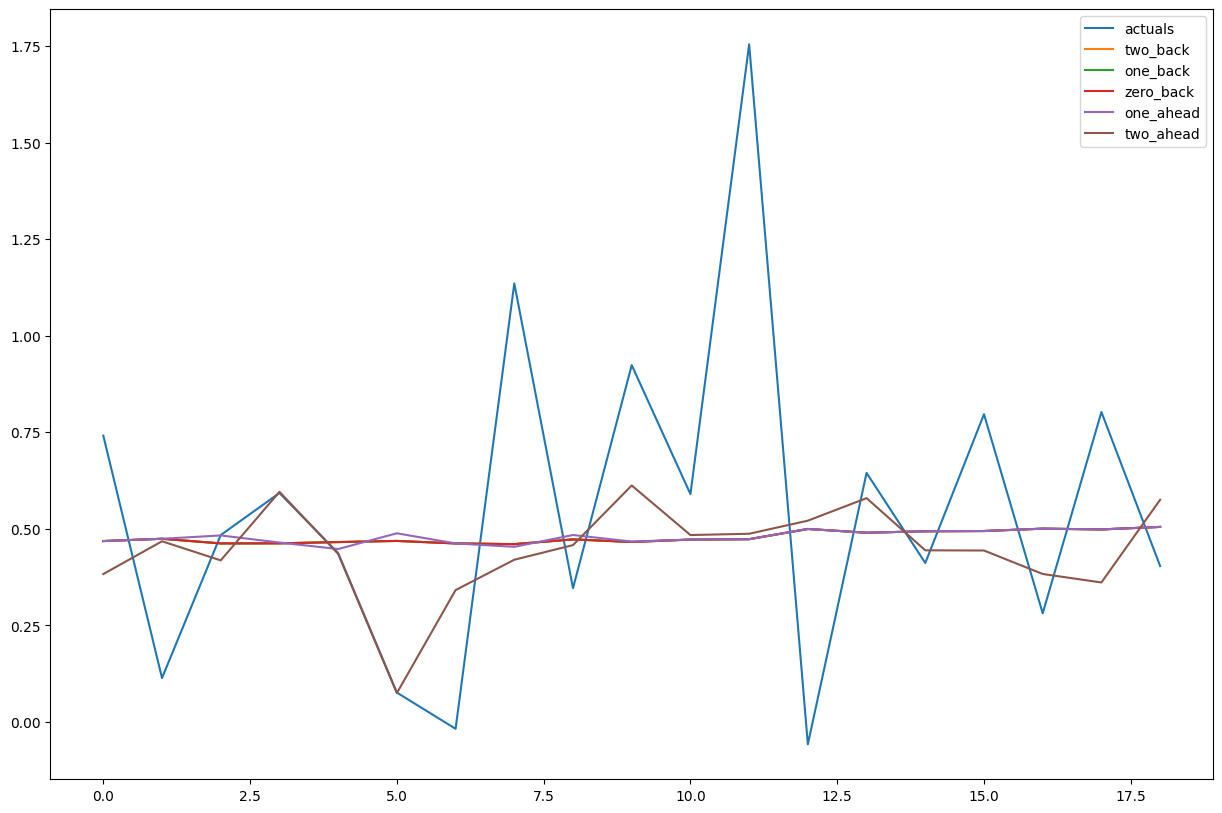

In [66]:
evaluate_elastic(data = data, target_variable='agri', model_params=agri_opt, plot=1, save=1)

In [11]:
def objective_mining(trial):
    dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

    actuals = list(test.loc[test.date.isin(dates), target_variable].values)

    pval = trial.suggest_loguniform('pval', 1e-3, 1)
    alpha = trial.suggest_loguniform('alpha', 1e-4, 1e4)
    l1 = trial.suggest_discrete_uniform('l1', 0, 1 , 0.01)
    flat = trial.suggest_int('flat', 2, 7, step=1)

    model_params = {'pval': pval, 'alpha': alpha, "l1": l1, "flat": flat}
    
    return nowcast_elastic(model_params, target_variable=target_variable, dates=dates, actuals=actuals)
    


In [12]:
target_variable = 'mining'
study = optuna.create_study()
study.optimize(objective_mining, n_trials = 100)
mining_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-25 21:45:32,167] A new study created in memory with name: no-name-b2a9ccfc-61b7-4da8-a413-c7cf70b216c4


[I 2024-04-25 21:45:46,219] Trial 0 finished with value: 2.1761370693144015 and parameters: {'pval': 0.08354159657241664, 'alpha': 30.607265731214223, 'l1': 0.29, 'flat': 7}. Best is trial 0 with value: 2.1761370693144015.
[I 2024-04-25 21:46:01,049] Trial 1 finished with value: 3.595894744445312 and parameters: {'pval': 0.1091214090688974, 'alpha': 0.01719624871509509, 'l1': 0.09, 'flat': 6}. Best is trial 0 with value: 2.1761370693144015.
[I 2024-04-25 21:46:07,405] Trial 2 finished with value: 2.119998927907225 and parameters: {'pval': 0.00796257705915422, 'alpha': 193.81306080778916, 'l1': 0.16, 'flat': 2}. Best is trial 2 with value: 2.119998927907225.
[I 2024-04-25 21:46:15,673] Trial 3 finished with value: 2.119998927907225 and parameters: {'pval': 0.012771631044304524, 'alpha': 278.32391826487174, 'l1': 0.09, 'flat': 5}. Best is trial 2 with value: 2.119998927907225.
[I 2024-04-25 21:46:25,769] Trial 4 finished with value: 2.97640126326767 and parameters: {'pval': 0.01806058717

Best MAE=2.1175475306495035, best parameters:{'pval': 0.024918102543993507, 'alpha': 422.7704956794155, 'l1': 0.8200000000000001, 'flat': 6}


In [ ]:
evaluate_elastic(data = data, target_variable='mining', model_params=mining_opt, plot=1, save=1)

In [14]:
target_variable = 'manufacturing'
study = optuna.create_study()
study.optimize(objective, n_trials = 200)
manufacturing_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-25 22:20:56,346] A new study created in memory with name: no-name-efe92242-df58-4a70-ae69-4b745308c75e
[I 2024-04-25 22:21:01,224] Trial 0 finished with value: 2.3331394262221163 and parameters: {'pval': 0.0008755042501403708, 'alpha': 85459.12295931253, 'l1': 0.5, 'flat': 5}. Best is trial 0 with value: 2.3331394262221163.
[I 2024-04-25 22:21:07,217] Trial 1 finished with value: 2.3550633408113586 and parameters: {'pval': 0.00035506698135392886, 'alpha': 197.43379614088093, 'l1': 0.30000000000000004, 'flat': 7}. Best is trial 0 with value: 2.3331394262221163.
[I 2024-04-25 22:21:12,287] Trial 2 finished with value: 3.246671576053076 and parameters: {'pval': 0.03591973330796705, 'alpha': 0.003948316108438655, 'l1': 0.6000000000000001, 'flat': 4}. Best is trial 0 with value: 2.3331394262221163.
[I 2024-04-25 22:21:14,895] Trial 3 finished with value: 2.3331394262221163 and parameters: {'pval': 4.5628037253357555e-05, 'alpha': 19.143042403343017, 'l1': 0.7000000000000001, 'fla

Best MAE=1.810674107830709, best parameters:{'pval': 0.045371971070244196, 'alpha': 0.020653365223625257, 'l1': 0.7000000000000001, 'flat': 2}


  Vintage    RMSE     MAE
0      -2  3.1514  2.2828
1      -1  2.7049  2.0138
2       0  2.5935  2.0219
3       1  2.2612  1.8591
4       2  2.1979  1.8107


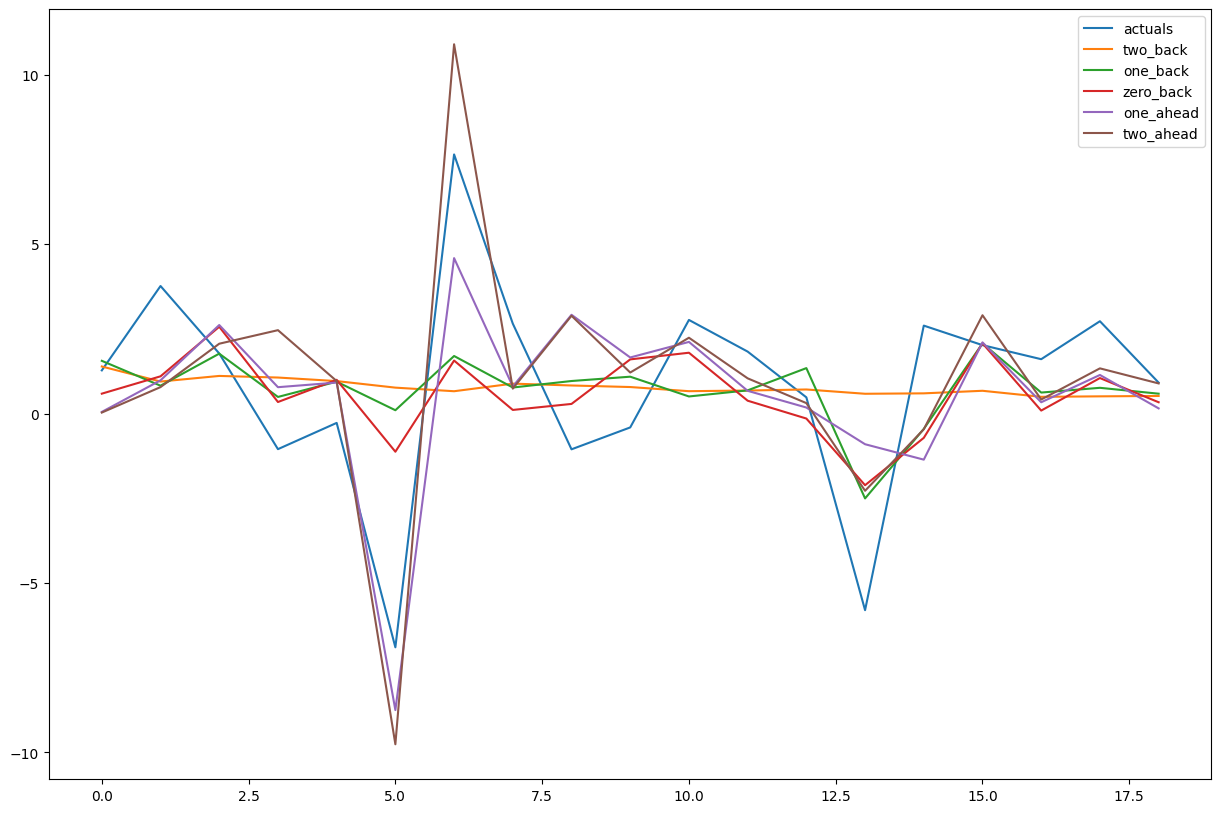

In [16]:
evaluate_elastic(data = data, target_variable='manufacturing', model_params=manufacturing_opt, plot=1, save=1)

In [17]:
target_variable = 'egpiv'
study = optuna.create_study()
study.optimize(objective, n_trials = 200)
egpiv_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-25 22:57:15,217] A new study created in memory with name: no-name-ddcafb37-5044-4db9-b68c-d4ee1cdccbc1
[I 2024-04-25 22:57:15,279] Trial 0 finished with value: 1000.0 and parameters: {'pval': 2.884937057876315e-05, 'alpha': 0.6909963911030218, 'l1': 0.0, 'flat': 5}. Best is trial 0 with value: 1000.0.
[I 2024-04-25 22:57:44,029] Trial 1 finished with value: 0.969367490722879 and parameters: {'pval': 0.5487499093357606, 'alpha': 11.357459513546518, 'l1': 0.30000000000000004, 'flat': 7}. Best is trial 1 with value: 0.969367490722879.
[I 2024-04-25 22:57:44,071] Trial 2 finished with value: 1000.0 and parameters: {'pval': 9.905359179803595e-05, 'alpha': 1651.0258094950448, 'l1': 1.0, 'flat': 5}. Best is trial 1 with value: 0.969367490722879.
[I 2024-04-25 22:57:55,643] Trial 3 finished with value: 0.994261792458514 and parameters: {'pval': 0.11100130652603658, 'alpha': 26405.173344590792, 'l1': 0.8, 'flat': 5}. Best is trial 1 with value: 0.969367490722879.
[I 2024-04-25 22:58:

Best MAE=0.7800677145000543, best parameters:{'pval': 0.11942675577967396, 'alpha': 1.1013230903022644, 'l1': 0.5, 'flat': 7}


  Vintage    RMSE     MAE
0      -2  1.2231  0.8071
1      -1  1.2458  0.8459
2       0  1.2588  0.8628
3       1  1.1883  0.7942
4       2  1.1843  0.7801


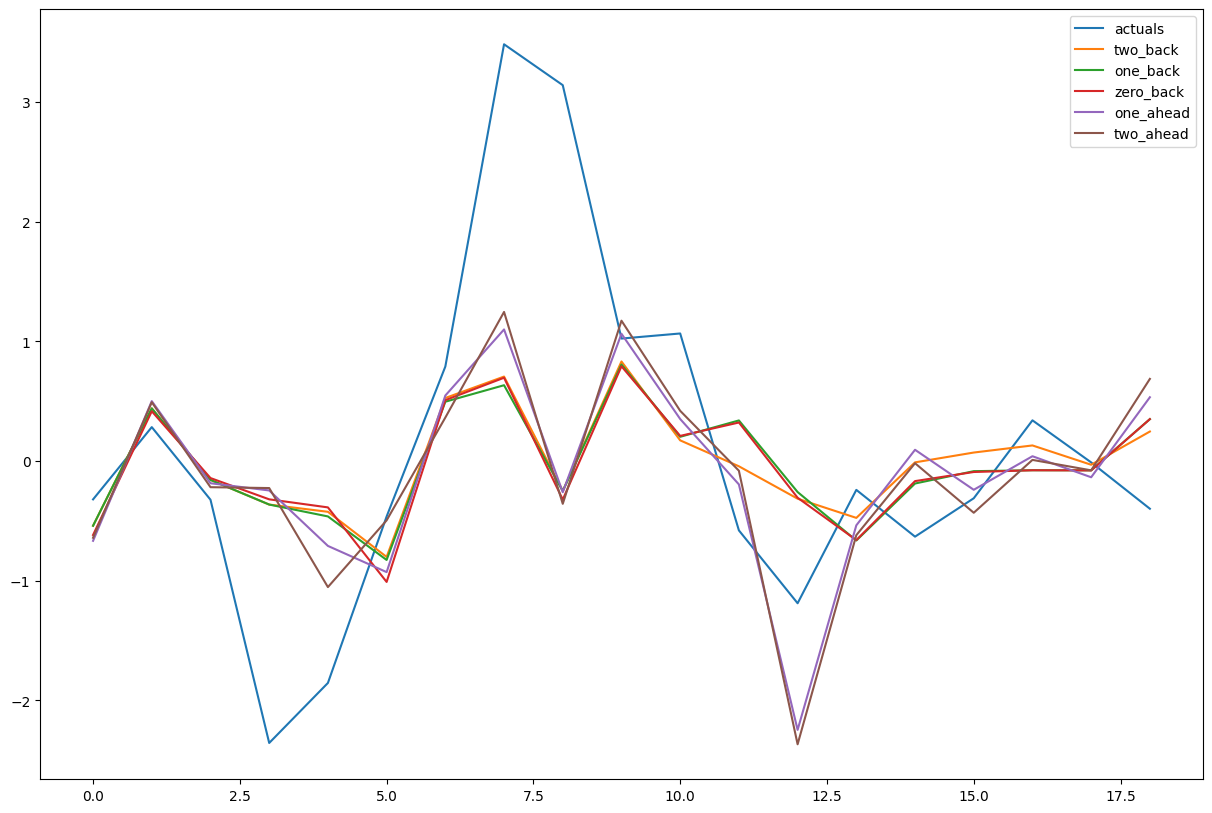

In [19]:
evaluate_elastic(data = data, target_variable='egpiv', model_params=egpiv_opt, plot=1, save=1)

In [20]:
target_variable = 'construction'
study = optuna.create_study()
study.optimize(objective, n_trials = 200)
construction_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 00:40:04,788] A new study created in memory with name: no-name-fbd5f564-3d2e-4eeb-a6bf-e6fe8d929257
[I 2024-04-26 00:40:08,519] Trial 0 finished with value: 3.367191078885275 and parameters: {'pval': 0.04606629735201391, 'alpha': 95559.93053617932, 'l1': 1.0, 'flat': 7}. Best is trial 0 with value: 3.367191078885275.
[I 2024-04-26 00:40:11,240] Trial 1 finished with value: 3.382762455482247 and parameters: {'pval': 1.0200160470791639e-05, 'alpha': 3.8370612904855603, 'l1': 1.0, 'flat': 7}. Best is trial 0 with value: 3.367191078885275.
[I 2024-04-26 00:40:14,976] Trial 2 finished with value: 3.3640709629826353 and parameters: {'pval': 0.25320097686607246, 'alpha': 33733.06821424728, 'l1': 0.9, 'flat': 3}. Best is trial 2 with value: 3.3640709629826353.
[I 2024-04-26 00:40:17,052] Trial 3 finished with value: 3.3640709629826353 and parameters: {'pval': 1.5871969216797326e-05, 'alpha': 1114.2485356362822, 'l1': 0.1, 'flat': 5}. Best is trial 2 with value: 3.3640709629826353

Best MAE=2.6753284872924046, best parameters:{'pval': 0.03386767993756911, 'alpha': 2.5257436706319387, 'l1': 0.2, 'flat': 7}


  Vintage    RMSE     MAE
0      -2  4.4000  3.4476
1      -1  4.1037  3.1981
2       0  4.1070  3.2063
3       1  3.8987  3.0930
4       2  3.4803  2.6753


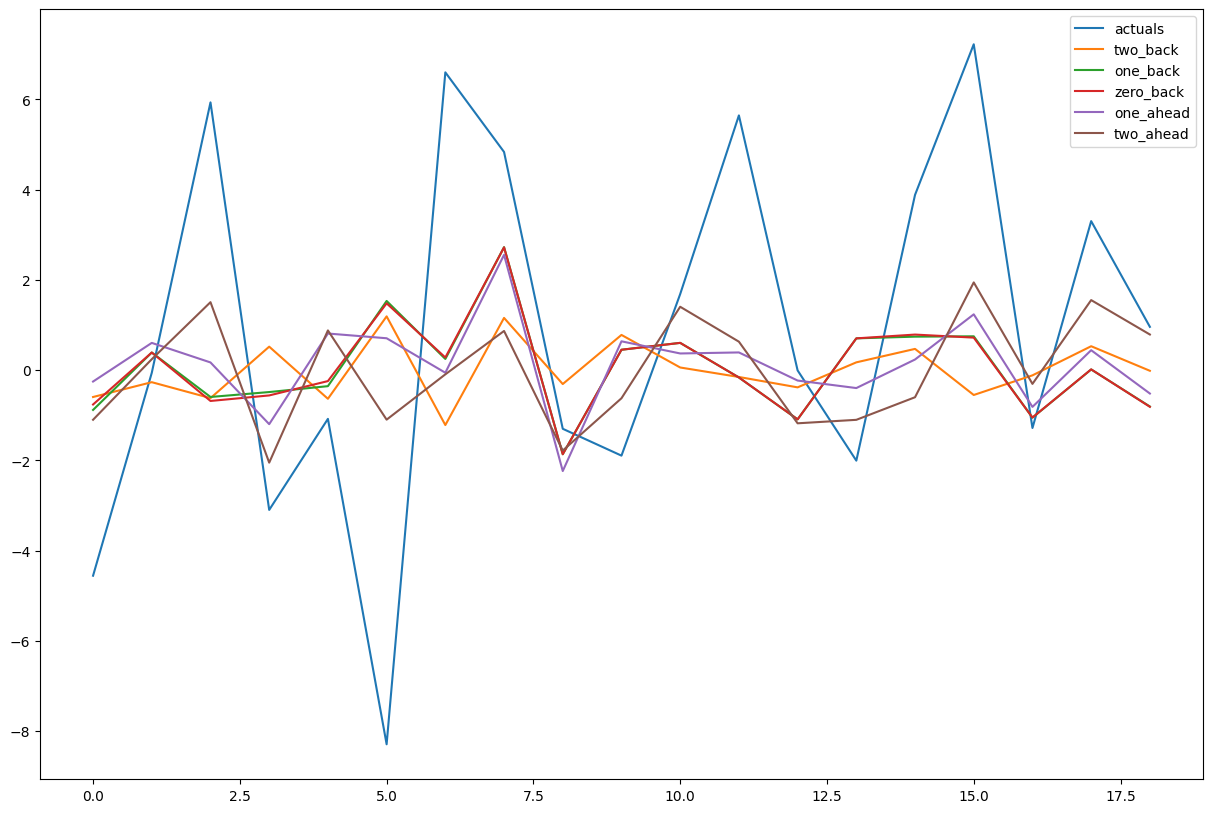

In [21]:
evaluate_elastic(data = data, target_variable='construction', model_params=construction_opt, plot=1, save=1)

In [22]:
target_variable = 'trade'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
trade_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 00:55:02,546] A new study created in memory with name: no-name-1c266f3c-08d3-4199-82a8-bbe229004bba
[I 2024-04-26 00:55:10,380] Trial 0 finished with value: 5.36232333953846 and parameters: {'pval': 0.0017854759024066495, 'alpha': 0.0010093890008700014, 'l1': 0.5, 'flat': 7}. Best is trial 0 with value: 5.36232333953846.
[I 2024-04-26 00:55:13,721] Trial 1 finished with value: 4.745983575691253 and parameters: {'pval': 1.6571659190635228e-05, 'alpha': 0.0774902338088471, 'l1': 0.8, 'flat': 2}. Best is trial 1 with value: 4.745983575691253.
[I 2024-04-26 00:55:20,539] Trial 2 finished with value: 5.227088109787925 and parameters: {'pval': 0.0010111497061298532, 'alpha': 0.012916134590494144, 'l1': 0.9, 'flat': 6}. Best is trial 1 with value: 4.745983575691253.
[I 2024-04-26 00:55:26,555] Trial 3 finished with value: 5.311543720638703 and parameters: {'pval': 0.0005329346648148425, 'alpha': 0.5207698046483853, 'l1': 0.1, 'flat': 5}. Best is trial 1 with value: 4.74598357569

Best MAE=2.5488649518543967, best parameters:{'pval': 0.6006991488966898, 'alpha': 0.30862986355358224, 'l1': 0.7000000000000001, 'flat': 7}


  Vintage    RMSE     MAE
0      -2  7.0071  4.1221
1      -1  6.9029  4.3078
2       0  5.4656  3.3513
3       1  5.1784  3.2987
4       2  4.5635  2.5489


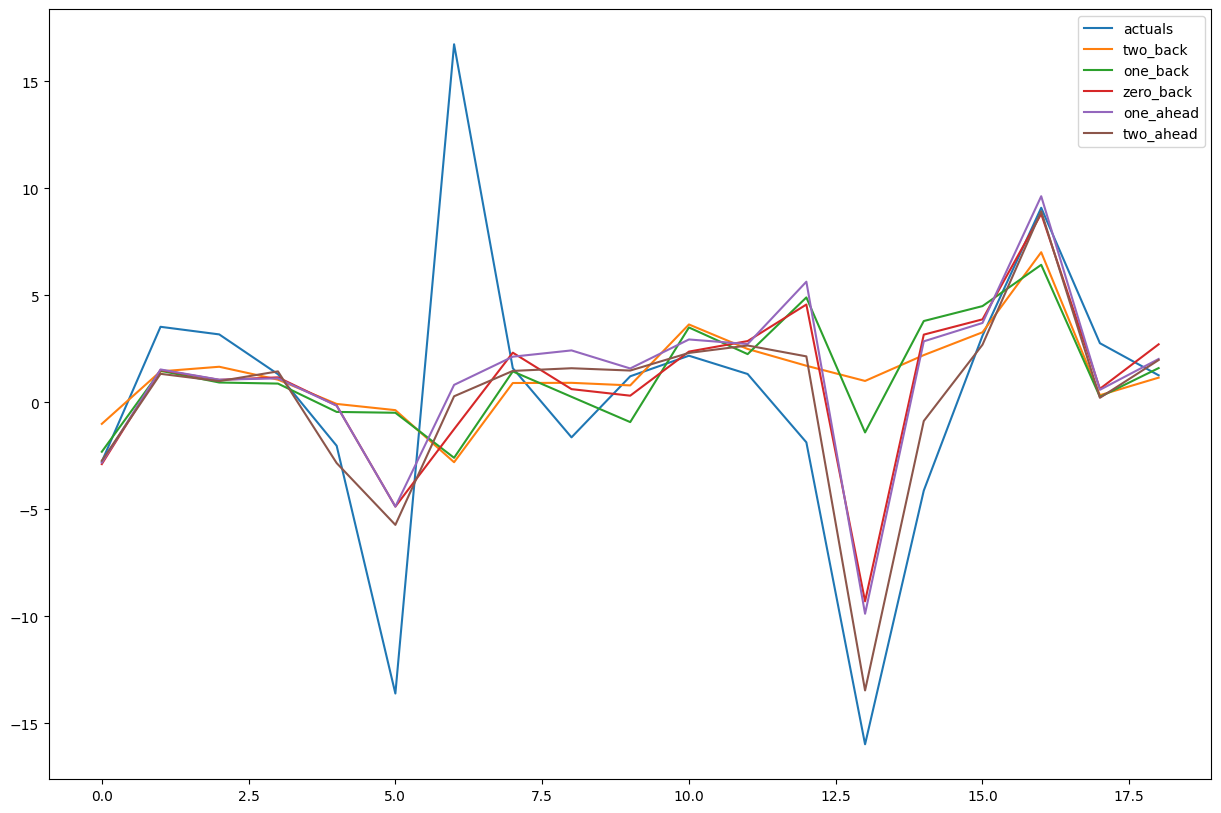

In [23]:
evaluate_elastic(data = data, target_variable='trade', model_params=trade_opt, plot=1, save=1)

In [24]:
target_variable = 'transport'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
transport_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 02:25:21,610] A new study created in memory with name: no-name-334ef1b1-03dc-455f-b065-42865926ef9b
[I 2024-04-26 02:25:25,393] Trial 0 finished with value: 3.834044074603836 and parameters: {'pval': 3.666063481145171e-05, 'alpha': 0.006099854288984231, 'l1': 0.4, 'flat': 6}. Best is trial 0 with value: 3.834044074603836.
[I 2024-04-26 02:25:30,170] Trial 1 finished with value: 3.026816083712223 and parameters: {'pval': 0.04279063349519622, 'alpha': 0.1935274896567177, 'l1': 0.2, 'flat': 5}. Best is trial 1 with value: 3.026816083712223.
[I 2024-04-26 02:25:33,224] Trial 2 finished with value: 3.564670146404009 and parameters: {'pval': 0.03050350697829437, 'alpha': 0.001669019447554104, 'l1': 0.4, 'flat': 2}. Best is trial 1 with value: 3.026816083712223.
[I 2024-04-26 02:25:36,398] Trial 3 finished with value: 3.755456447261442 and parameters: {'pval': 0.0034512312619655447, 'alpha': 0.016258403808515214, 'l1': 0.0, 'flat': 3}. Best is trial 1 with value: 3.0268160837122

Best MAE=2.475658136458613, best parameters:{'pval': 3.741521222358029e-05, 'alpha': 0.4889916013668222, 'l1': 0.30000000000000004, 'flat': 6}


  Vintage    RMSE     MAE
0      -2  4.7683  2.6843
1      -1  4.7680  2.6024
2       0  4.7958  2.6335
3       1  4.0149  2.3553
4       2  4.0625  2.4757


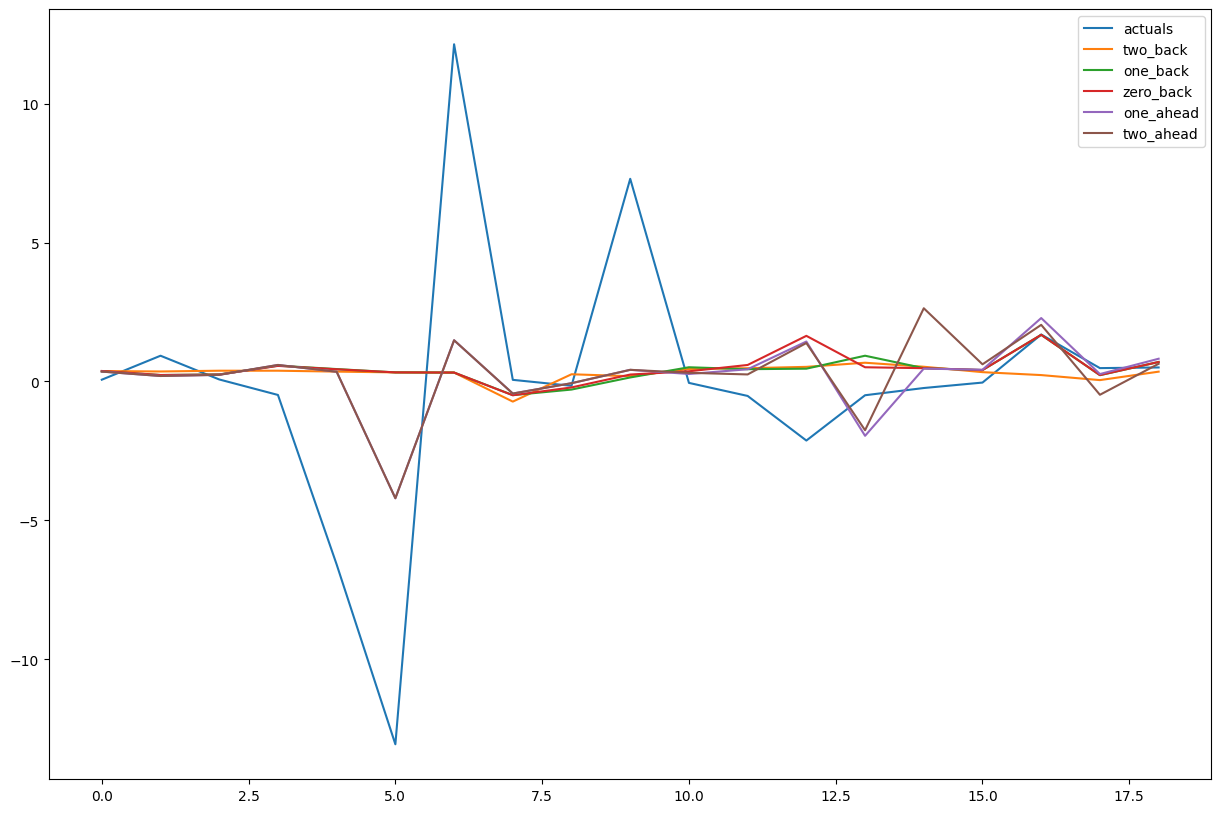

In [25]:
evaluate_elastic(data = data, target_variable='transport', model_params=transport_opt, plot=1, save=1)

In [26]:
target_variable = 'finance'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
finance_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 02:35:10,248] A new study created in memory with name: no-name-05b5b98d-ec6b-47aa-982f-44921d2e90a7
[I 2024-04-26 02:35:10,301] Trial 0 finished with value: 1000.0 and parameters: {'pval': 2.8903969959761186e-05, 'alpha': 0.004516007720765543, 'l1': 1.0, 'flat': 6}. Best is trial 0 with value: 1000.0.
[I 2024-04-26 02:35:15,734] Trial 1 finished with value: 3.0468138614674403 and parameters: {'pval': 0.08711070878670302, 'alpha': 0.5334070310747568, 'l1': 0.9, 'flat': 7}. Best is trial 1 with value: 3.0468138614674403.
[I 2024-04-26 02:35:17,661] Trial 2 finished with value: 1.8054024512999596 and parameters: {'pval': 0.014129190761906031, 'alpha': 2910.3382099753435, 'l1': 0.4, 'flat': 2}. Best is trial 2 with value: 1.8054024512999596.
[I 2024-04-26 02:35:17,679] Trial 3 finished with value: 1000.0 and parameters: {'pval': 0.00010783170223820552, 'alpha': 1.0372971510539433, 'l1': 0.8, 'flat': 2}. Best is trial 2 with value: 1.8054024512999596.
[I 2024-04-26 02:35:28,18

Best MAE=1.7102444919185842, best parameters:{'pval': 0.0014630014727528913, 'alpha': 0.13097713226648805, 'l1': 0.1, 'flat': 6}


  Vintage    RMSE     MAE
0      -2  2.0625  1.6896
1      -1  2.4362  1.8768
2       0  2.9696  2.4228
3       1  2.1602  1.7320
4       2  2.1222  1.7102


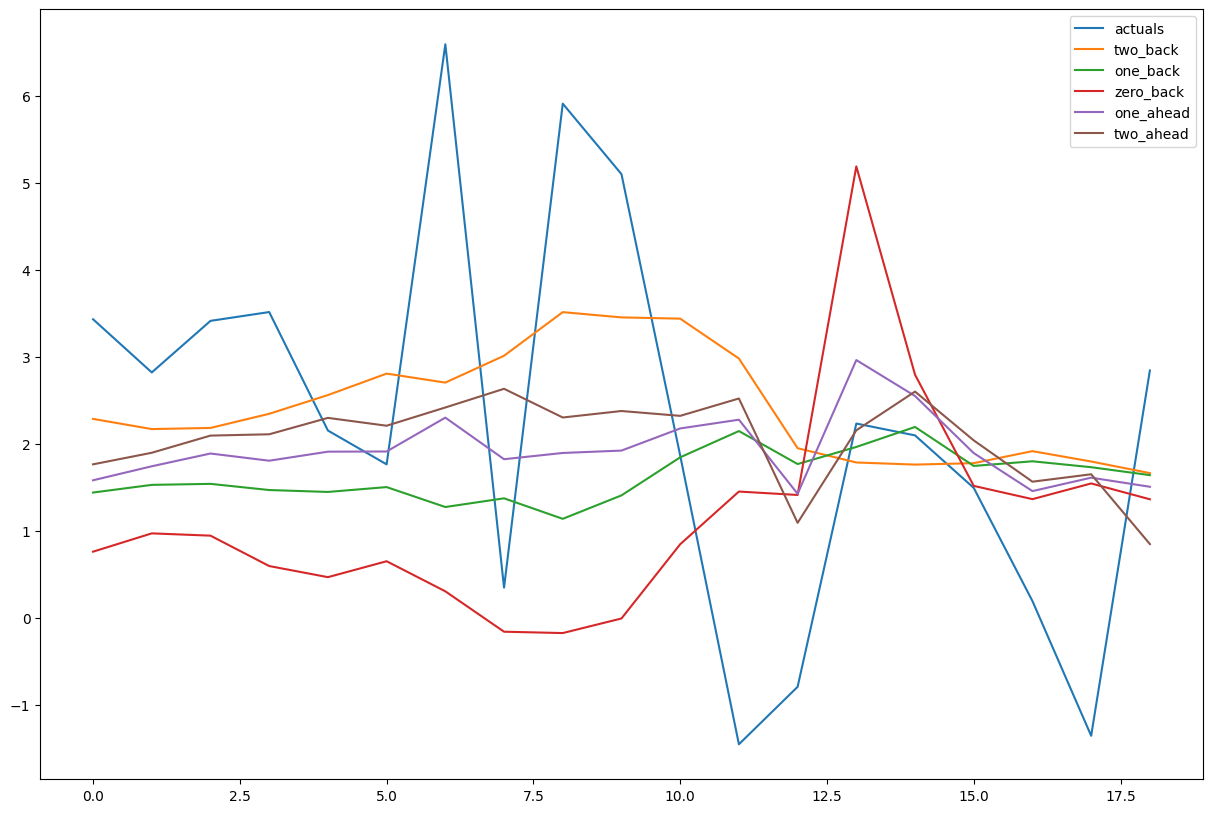

In [27]:
evaluate_elastic(data = data, target_variable='finance', model_params=finance_opt, plot=1, save=1)

In [28]:
target_variable = 'real_estate'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
real_estate_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 02:42:02,750] A new study created in memory with name: no-name-a487e94d-e0cd-46b8-b600-e4839c71cd01
[I 2024-04-26 02:42:17,030] Trial 0 finished with value: 0.9335858510529217 and parameters: {'pval': 0.5271091418312125, 'alpha': 0.0034483922858730195, 'l1': 0.1, 'flat': 7}. Best is trial 0 with value: 0.9335858510529217.
[I 2024-04-26 02:42:34,777] Trial 1 finished with value: 1.6289037950359069 and parameters: {'pval': 0.9904497696595814, 'alpha': 1.1780434290660673, 'l1': 0.5, 'flat': 5}. Best is trial 0 with value: 0.9335858510529217.
[I 2024-04-26 02:42:34,797] Trial 2 finished with value: 1000.0 and parameters: {'pval': 0.0001388074933047532, 'alpha': 27.649676595705458, 'l1': 1.0, 'flat': 2}. Best is trial 0 with value: 0.9335858510529217.
[I 2024-04-26 02:42:34,832] Trial 3 finished with value: 1000.0 and parameters: {'pval': 2.217427687522065e-05, 'alpha': 4279.389160622867, 'l1': 1.0, 'flat': 7}. Best is trial 0 with value: 0.9335858510529217.
[I 2024-04-26 02:4

Best MAE=0.7783399013942793, best parameters:{'pval': 0.6205090297414056, 'alpha': 0.013235201001366971, 'l1': 0.0, 'flat': 7}


  Vintage    RMSE     MAE
0      -2  1.5637  1.1382
1      -1  1.4737  1.0644
2       0  1.1926  0.8616
3       1  1.2589  0.9348
4       2  1.1143  0.7783


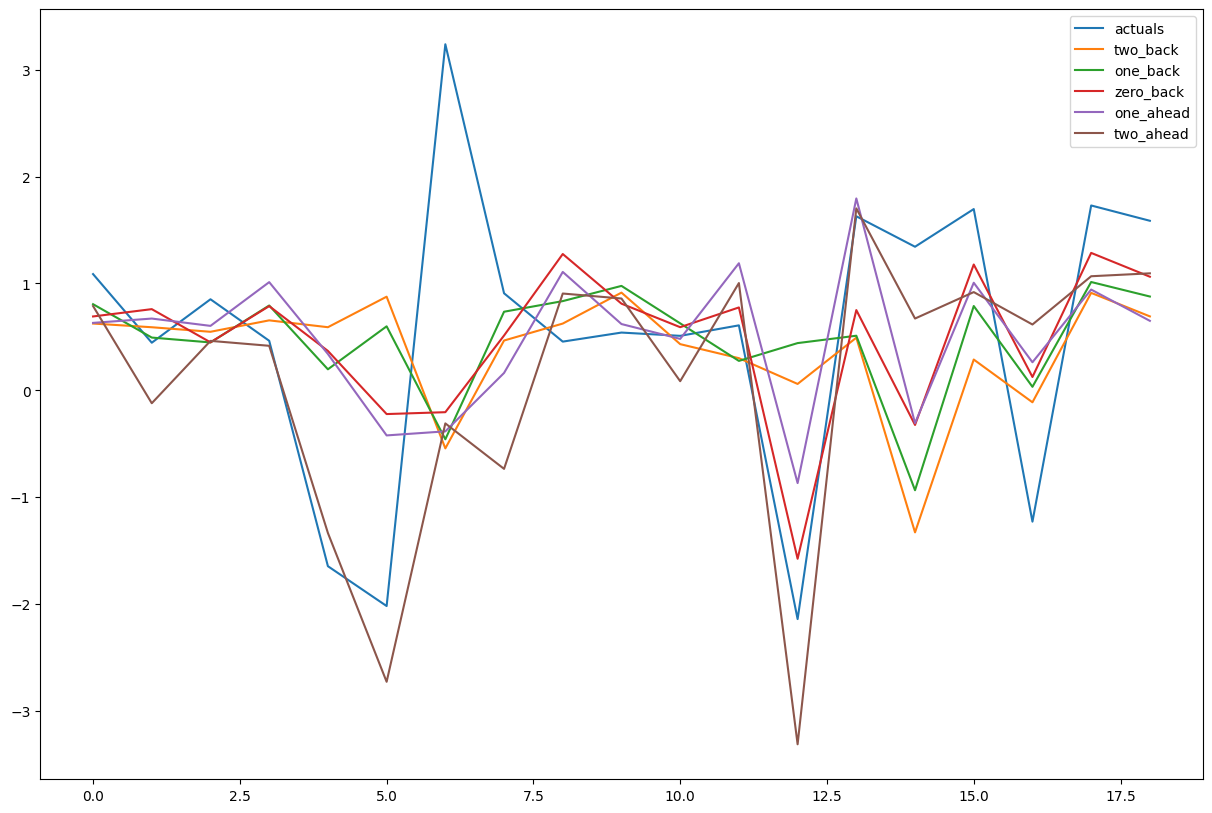

In [29]:
evaluate_elastic(data = data, target_variable='real_estate', model_params=real_estate_opt, plot=1, save=1)

In [30]:
target_variable = 'others'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
others_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 03:11:23,756] A new study created in memory with name: no-name-d5bbafae-523c-4224-9d5b-4d8e2f224917
[I 2024-04-26 03:11:27,360] Trial 0 finished with value: 2.858805070873644 and parameters: {'pval': 0.020394917232042536, 'alpha': 4.967327678929834, 'l1': 0.1, 'flat': 3}. Best is trial 0 with value: 2.858805070873644.
[I 2024-04-26 03:11:31,267] Trial 1 finished with value: 3.480220202999804 and parameters: {'pval': 0.03291101662406326, 'alpha': 2470.154641587259, 'l1': 0.8, 'flat': 4}. Best is trial 0 with value: 2.858805070873644.
[I 2024-04-26 03:11:38,356] Trial 2 finished with value: 3.687769279956683 and parameters: {'pval': 0.13846440187112266, 'alpha': 0.002691064222880936, 'l1': 0.8, 'flat': 6}. Best is trial 0 with value: 2.858805070873644.
[I 2024-04-26 03:11:42,839] Trial 3 finished with value: 3.456427405420972 and parameters: {'pval': 0.001472273940270097, 'alpha': 173.9209702439029, 'l1': 0.1, 'flat': 7}. Best is trial 0 with value: 2.858805070873644.
[I 20

Best MAE=1.9008217534219518, best parameters:{'pval': 0.005512772821122981, 'alpha': 0.20899490161071865, 'l1': 0.2, 'flat': 5}


  Vintage    RMSE     MAE
0      -2  4.1410  3.1969
1      -1  3.4771  2.5043
2       0  3.8181  2.6658
3       1  2.8774  2.3399
4       2  2.3287  1.9008


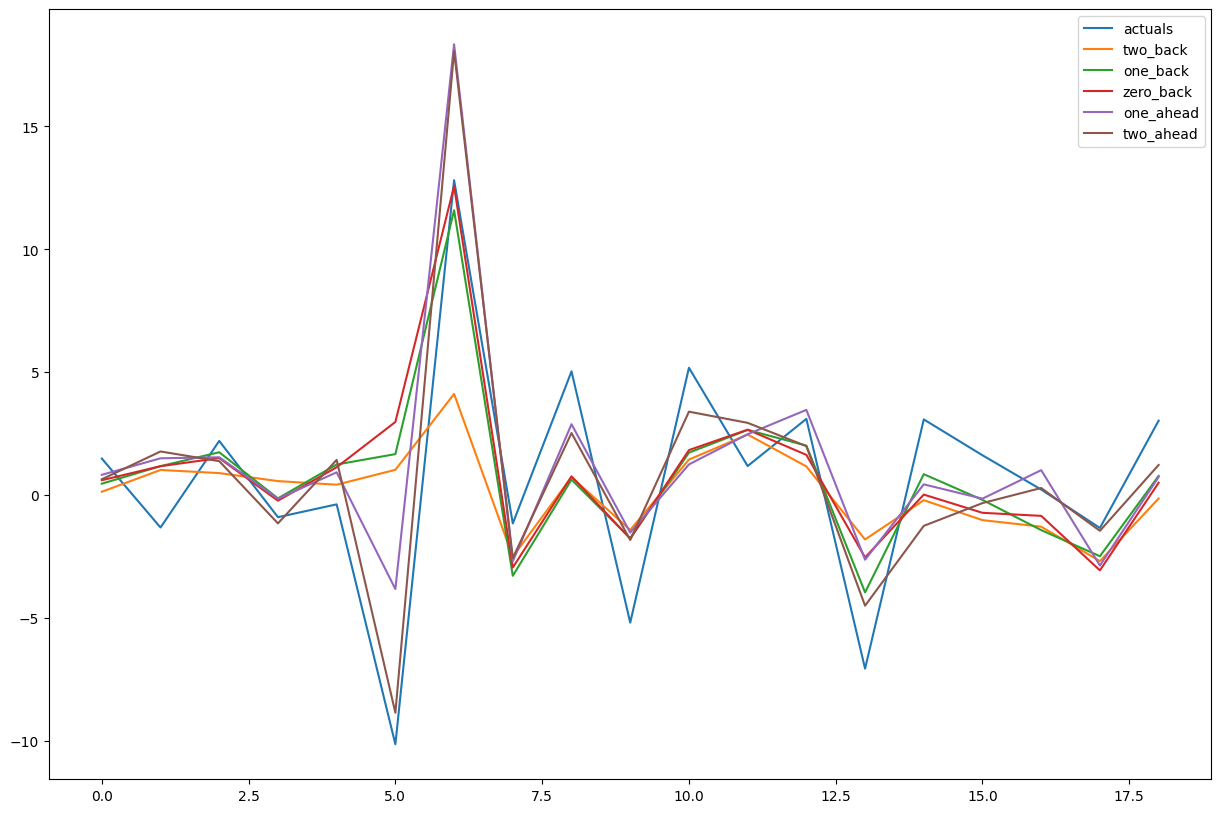

In [31]:
evaluate_elastic(data = data, target_variable='others', model_params=others_opt, plot=1, save=1)

In [32]:
target_variable = 'taxes'
study = optuna.create_study()
study.optimize(objective, n_trials = 150)
taxes_opt = study.best_params
print(f'Best MAE={study.best_value}, best parameters:{study.best_params}')

[I 2024-04-26 03:21:55,029] A new study created in memory with name: no-name-857c765d-7949-43b9-9a6d-2822fddf3e57
[I 2024-04-26 03:22:03,593] Trial 0 finished with value: 2.659760264624016 and parameters: {'pval': 0.10788140547158075, 'alpha': 0.5832118877739193, 'l1': 0.8, 'flat': 5}. Best is trial 0 with value: 2.659760264624016.
[I 2024-04-26 03:22:08,261] Trial 1 finished with value: 3.098272275031646 and parameters: {'pval': 0.0003427081859837685, 'alpha': 0.5969592077128577, 'l1': 0.2, 'flat': 7}. Best is trial 0 with value: 2.659760264624016.
[I 2024-04-26 03:22:10,371] Trial 2 finished with value: 2.649887807285343 and parameters: {'pval': 2.1746044795827033e-05, 'alpha': 0.016892808197271934, 'l1': 0.5, 'flat': 2}. Best is trial 2 with value: 2.649887807285343.
[I 2024-04-26 03:22:14,352] Trial 3 finished with value: 2.6604280364725654 and parameters: {'pval': 7.189728376347568e-05, 'alpha': 44.0686485020003, 'l1': 1.0, 'flat': 6}. Best is trial 2 with value: 2.649887807285343

Best MAE=2.1636378775120493, best parameters:{'pval': 0.07129648503785536, 'alpha': 5.1999560094681945, 'l1': 0.8, 'flat': 6}


  Vintage    RMSE     MAE
0      -2  4.0460  2.3769
1      -1  4.0954  2.4007
2       0  3.3062  2.1362
3       1  3.3544  2.1539
4       2  3.3650  2.1636


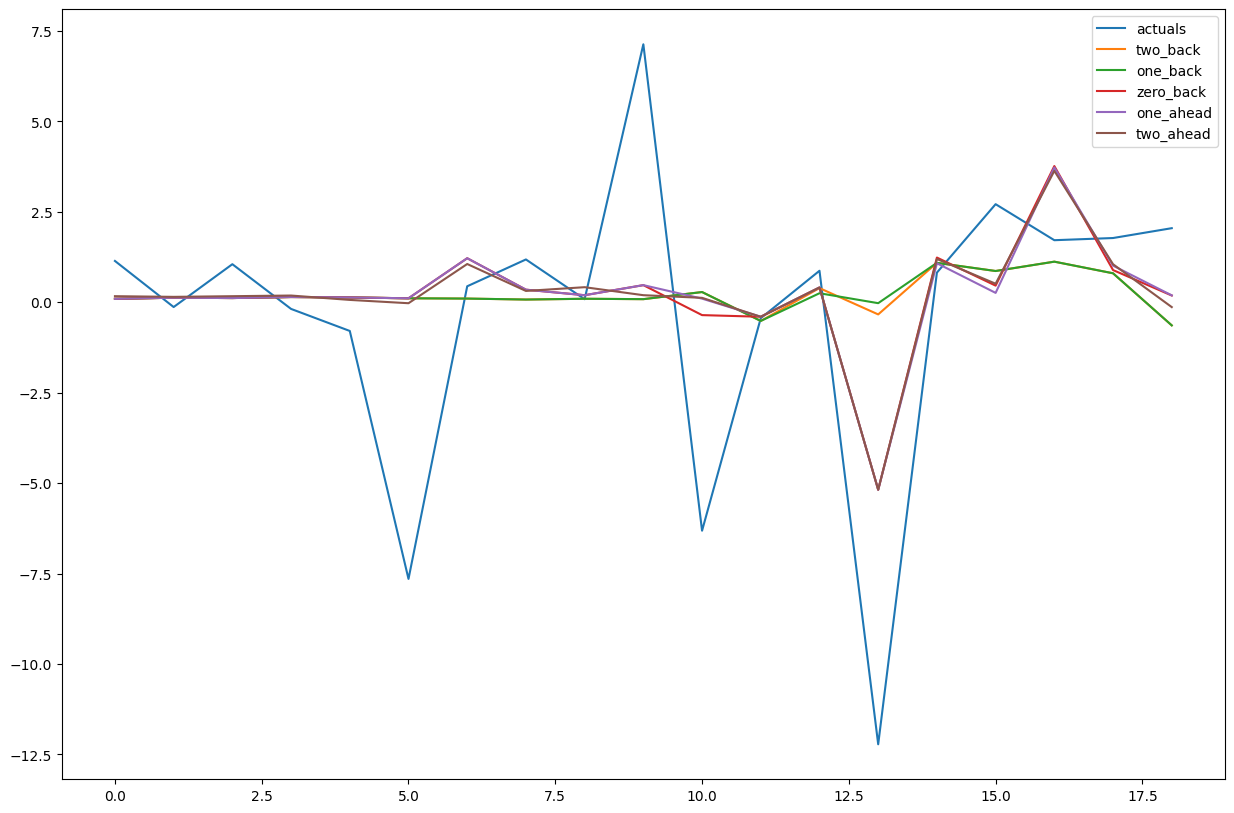

In [33]:
evaluate_elastic(data = data, target_variable='taxes', model_params=taxes_opt, plot=1, save=1)